# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**

Датасет содержит исторические данные: технические характеристики, комплектации и цены автомобилей. 

Необходимо построить модель для определения стоимости.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd #импорт библиотек

import numpy as np

import lightgbm as lgb

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

In [2]:
try: # чтение файла с сайта
    df = pd.read_csv('/datasets/autos.csv')
except: # чтение файла локально
    df = pd.read_csv('datasets\\autos.csv')

### Обзор данных

In [3]:
display(df.head())
print('--------------------------------------')
print('Размер:')
print(df.shape)
print('--------------------------------------')
print('Информация:')
print(df.info())
print('--------------------------------------')
print('Дубликаты:')
print(df.duplicated().sum())
print('--------------------------------------')
print('Пропуски:')
print(df.isna().sum())
print('--------------------------------------')
print('Описание данных:')
display(df.describe(include='all'))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


--------------------------------------
Размер:
(354369, 16)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  Posta

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


По описанию данных, названия столбцов написаны в "верблюжьем регистре". Проверим. 

In [4]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Названия столбцов заменим на 'змеиный регистр'.

In [5]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.columns # проверка

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Посмотрим на дубликаты:

In [6]:
df[df.duplicated(keep=False)].sort_values(by = 'price')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


Восемь строк, четыре дубликата. Кажется, их можно безболезненно удалить.

In [7]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()  # проверка

0

### Удаление колонок.

#### Столбцы "date_crawled", "date_created", "last_seen"

Столбцы с датами обычно нужно преобразовать в формат даты и времени. 

Но дата скачивания данных из базы, дата последней активности пользователя и дата создания анкеты не влияют на цену автомобиля. Эти столбцы следует удалить.

In [8]:
df = df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'number_of_pictures', 'postal_code'],
      dtype='object')

#### Столбец "postal_code"

Почтовый индекс не может влиять на стоимость автомобиля. 

Удаляем этот столбец.

In [9]:
df = df.drop('postal_code', axis=1)
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'number_of_pictures'],
      dtype='object')

Неинформативные столбцы  удалены.

### Заполнение пропусков

#### Столбец "vehicle_type".

Посмотрим, какие значения встречаются в столбце:

In [10]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Значений не много, это упрощает задачу.

Посмотрим на примеры пропусков:

In [11]:
df[df['vehicle_type'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0
16,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,0
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,0
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,0
31,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,0


В выборку попали разные автомобили. Посмотрим на нескольких примерах, можно ли по модели однозначно определить тип кузова:

In [12]:
display(df[df['model'] == 'meriva'].head(3))
print('Типы кузова:', df[df['model'] == 'meriva']['vehicle_type'].unique())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,0
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,0
1066,2250,NaN,2017,manual,90,meriva,150000,10,NaN,opel,NaN,0


Типы кузова: [nan 'bus' 'suv' 'wagon' 'small' 'sedan' 'other' 'coupe']


In [13]:
display(df[df['model'] == 'kangoo'].head(3))
print('Типы кузова:', df[df['model'] == 'kangoo']['vehicle_type'].unique())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
37,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,0
333,600,bus,2001,manual,75,kangoo,150000,12,petrol,renault,yes,0
690,400,NaN,2016,manual,0,kangoo,150000,0,gasoline,renault,yes,0


Типы кузова: [nan 'bus' 'wagon' 'other' 'small' 'sedan' 'suv']


In [14]:
display(df[df['model'] == 'clio'].head(3))
print('Типы кузова:', df[df['model'] == 'clio']['vehicle_type'].unique())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
31,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,0
45,590,small,1999,manual,75,clio,125000,8,petrol,renault,no,0
142,800,small,1998,manual,54,clio,150000,11,petrol,renault,no,0


Типы кузова: [nan 'small' 'wagon' 'sedan' 'coupe' 'convertible' 'other']


In [15]:
display(df[df['model'] == '159'].head(3))
print('Типы кузова:', df[df['model'] == '159']['vehicle_type'].unique())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
729,5000,sedan,2006,manual,185,159,125000,12,NaN,alfa_romeo,no,0
893,5500,sedan,2006,manual,150,159,150000,11,gasoline,alfa_romeo,no,0
2528,7250,wagon,2007,manual,150,159,150000,7,gasoline,alfa_romeo,no,0


Типы кузова: ['sedan' 'wagon' nan]


Похоже, у большинство моделей выпускаются в нескольких типах кузова. Посмотрим полный список моделей, у которых только один указанный тип кузова:

In [16]:
for model in df[df['vehicle_type'].isna()]['model'].unique():
    if df[df['model'] == model]['vehicle_type'].nunique() == 1:
        print('Модель:', model)
        print('Типы кузова:', df[df['model'] == model]['vehicle_type'].unique())

Модель: s60
Типы кузова: ['sedan' nan]
Модель: cherokee
Типы кузова: ['suv' nan]
Модель: phaeton
Типы кузова: ['sedan' nan]
Модель: eos
Типы кузова: ['convertible' nan]
Модель: captiva
Типы кузова: ['suv' nan]
Модель: range_rover
Типы кузова: ['suv' nan]
Модель: serie_3
Типы кузова: ['suv' nan]
Модель: b_max
Типы кузова: ['bus' nan]
Модель: serie_1
Типы кузова: ['wagon' nan]


Найдены модели автомобилей, у которых можно однозначно определить тип кузова. Заполним пропуски:

In [17]:
for model in df[df['vehicle_type'].isna()]['model'].unique():
    if df[df['model'] == model]['vehicle_type'].nunique() == 1:
        print('Модель:', model)
        df.loc[
            df['model'] == model, 'vehicle_type'
        ] = df.loc[
            df['model'] == model, 'vehicle_type'
        ].fillna(df.loc[
            df['model'] == model, 'vehicle_type'
        ].sort_values().unique()[0])
        print('Типы кузова:', df[df['model'] == model]['vehicle_type'].unique())

Модель: s60
Типы кузова: ['sedan']
Модель: cherokee
Типы кузова: ['suv']
Модель: phaeton
Типы кузова: ['sedan']
Модель: eos
Типы кузова: ['convertible']
Модель: captiva
Типы кузова: ['suv']
Модель: range_rover
Типы кузова: ['suv']
Модель: serie_3
Типы кузова: ['suv']
Модель: b_max
Типы кузова: ['bus']
Модель: serie_1
Типы кузова: ['wagon']


In [18]:
df['vehicle_type'].isna().sum()

37428

Успешно заполнены 37490 - 37428 = 62 пропуска.

Остальные пропуски придётся заполнить значением "unknown", поскольку заполнить их корректно нет возможности, а модели ML не смогут работать с пропусками.

In [19]:
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')
df['vehicle_type'].isna().sum()

0

#### Столбец "gearbox".

Посмотрим, какие значения встречаются в столбце:

In [20]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Всего два варианта.

Посмотрим на примеры пропусков:

In [21]:
df[df['gearbox'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,0
16,300,unknown,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,0
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,0
37,1500,unknown,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,0
40,0,unknown,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,0


Посмотрим, есть ли модели, у которых только один тип КПП:

In [22]:
for model in df.loc[df['gearbox'].isna(),'model'].sort_values().unique():
    if df[df['model'] == model]['gearbox'].nunique() == 1:
        print('Модель:', model)
        print('Типы КПП:', df[df['model'] == model]['gearbox'].unique())

Модель: 145
Типы КПП: ['manual' nan]
Модель: duster
Типы КПП: ['manual' nan]
Модель: fox
Типы КПП: ['manual' nan]
Модель: lodgy
Типы КПП: ['manual' nan]
Модель: logan
Типы КПП: ['manual' nan]
Модель: niva
Типы КПП: ['manual' nan]
Модель: serie_1
Типы КПП: ['manual' nan]
Модель: serie_3
Типы КПП: ['manual' nan]
Модель: spark
Типы КПП: ['manual' nan]


Найдены модели автомобилей, у которых можно однозначно определить тип КПП. Заполним пропуски:

In [23]:
for model in df[df['gearbox'].isna()]['model'].sort_values().unique():
    if df[df['model'] == model]['gearbox'].nunique() == 1:
        print('Модель:', model)
        df.loc[
            df['model'] == model, 'gearbox'
        ] = df.loc[
            df['model'] == model, 'gearbox'
        ].fillna(df.loc[
            df['model'] == model, 'gearbox'
        ].sort_values().unique()[0])
        print('Типы КПП:', df.loc[df['model'] == model,'gearbox'].unique())

Модель: 145
Типы КПП: ['manual']
Модель: duster
Типы КПП: ['manual']
Модель: fox
Типы КПП: ['manual']
Модель: lodgy
Типы КПП: ['manual']
Модель: logan
Типы КПП: ['manual']
Модель: niva
Типы КПП: ['manual']
Модель: serie_1
Типы КПП: ['manual']
Модель: serie_3
Типы КПП: ['manual']
Модель: spark
Типы КПП: ['manual']


In [24]:
df['gearbox'].isna().sum()

19755

Успешно заполнены 19833 - 19755 = 78 пропуска.

Остальные пропуски придётся заполнить значением "unknown", поскольку заполнить их корректно нет возможности, а модели ML не смогут работать с пропусками.

In [25]:
df['gearbox'] = df['gearbox'].fillna('unknown')
df['gearbox'].isna().sum()

0

#### Столбец "model".

Посмотрим, какие значения встречаются в столбце:

In [26]:
df['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Множество вариантов.

Посмотрим на примеры пропусков:

In [27]:
df[df['model'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,0
81,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,0
115,0,small,1999,unknown,0,NaN,5000,0,petrol,volkswagen,NaN,0
135,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,0


Есть ли шанс заполнить модель по производителю?

In [28]:
for brand in df.loc[df['model'].isna(),'brand'].sort_values().unique():
    if df.loc[df['brand'] == brand, 'model'].nunique() == 1:
        print('Производитель:', brand)
        print('Модели:', df[df['brand'] == brand]['model'].unique())

Таких нет.

Заполним пропуски значением "unknown". Также заменим на "unknown" значения "other", это будет фактически одно и то же, так будет единообразнее.

In [29]:
df['model'] = df['model'].fillna('unknown') #заполнение
df['model'] = df['model'].replace('other', 'unknown') # замена 
print(df['model'].isna().sum())  # проверка заполнения
print(len(df.loc[df['model'] == 'other'])) # проверка замены

0
0


#### Столбец "fuel_type".

Посмотрим, какие значения встречаются в столбце:

In [30]:
df['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

Немного вариантов.

Посмотрим на примеры пропусков:

In [31]:
df[df['fuel_type'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,0
13,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,0
26,5555,unknown,2017,manual,125,c4,125000,4,NaN,citroen,no,0
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,0
41,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,0


Посмотрим, есть ли модели, у которых только один тип топлива:

In [32]:
for model in df.loc[df['fuel_type'].isna(),'model'].sort_values().unique():
    if df[df['model'] == model]['fuel_type'].nunique() == 1:
        print('Модель:', model)
        print('Типы топлива:', df[df['model'] == model]['fuel_type'].sort_values().unique())

Модель: 200
Типы топлива: ['petrol' nan]
Модель: 90
Типы топлива: ['petrol' nan]
Модель: 911
Типы топлива: ['petrol' nan]
Модель: boxster
Типы топлива: ['petrol' nan]
Модель: charade
Типы топлива: ['petrol' nan]
Модель: elefantino
Типы топлива: ['petrol' nan]
Модель: kadett
Типы топлива: ['petrol' nan]
Модель: move
Типы топлива: ['petrol' nan]
Модель: r19
Типы топлива: ['petrol' nan]


Найдены модели автомобилей, у которых можно однозначно определить тип топлива. Заполним пропуски:

In [33]:
for model in df[df['fuel_type'].isna()]['model'].sort_values().unique():
    if df[df['model'] == model]['fuel_type'].nunique() == 1:
        print('Модель:', model)
        df.loc[
            df['model'] == model, 'fuel_type'
        ] = df.loc[
            df['model'] == model, 'fuel_type'
        ].fillna(df.loc[
            df['model'] == model, 'fuel_type'
        ].sort_values().unique()[0])
        print('Типы топлива:', df.loc[df['model'] == model,'fuel_type'].unique())

Модель: 200
Типы топлива: ['petrol']
Модель: 90
Типы топлива: ['petrol']
Модель: 911
Типы топлива: ['petrol']
Модель: boxster
Типы топлива: ['petrol']
Модель: charade
Типы топлива: ['petrol']
Модель: elefantino
Типы топлива: ['petrol']
Модель: kadett
Типы топлива: ['petrol']
Модель: move
Типы топлива: ['petrol']
Модель: r19
Типы топлива: ['petrol']


In [34]:
df['fuel_type'].isna().sum()

32737

Успешно заполнены 32895 - 32737 = 158 пропусков.

Остальные пропуски придётся заполнить значением "unknown", поскольку заполнить их корректно нет возможности, а модели ML не смогут работать с пропусками.

In [35]:
df['fuel_type'] = df['fuel_type'].fillna('unknown')
df['fuel_type'].isna().sum()

0

#### Столбец "not_repaired".

Посмотрим, какие значения встречаются в столбце:

In [36]:
df['not_repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

Всего два смысловых варианта. В идеале можно было бы преобразовать в булевый тип данных, но 71 154 пропусков не позволят этого сделать.

Посмотрим на примеры пропусков:

In [37]:
df[df['not_repaired'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,0
9,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,NaN,0
12,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,0


Заполним пропуски значением "unknown", поскольку заполнить их корректно нет возможности, а модели ML не смогут работать с пропусками.

In [38]:
df['not_repaired'] = df['not_repaired'].fillna('unknown')
df['not_repaired'].isna().sum()

0

### Выявление аномалий

#### Столбец "registration_year"

Посмотрим на "ящик с усами" для этого столбца:

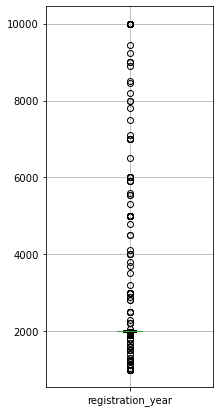

In [39]:
df[['registration_year']].boxplot(figsize = (3, 7));

Множество неправдоподобных значений.

Посмотрим на частотную гистограмму:

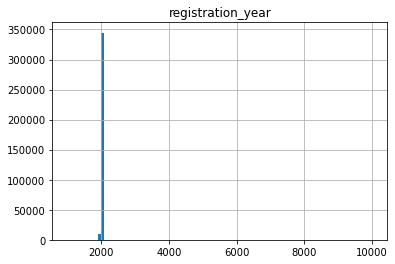

In [40]:
df.hist(column='registration_year', bins = 100);

Приблизим значения до 1900 года:

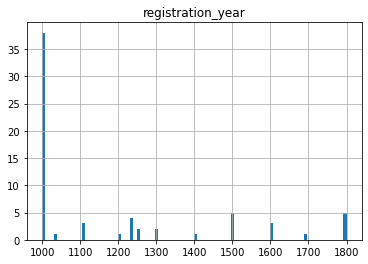

In [41]:
df[df['registration_year']<1900].hist(column='registration_year', bins = 100);

Посмотрим на строки с такими значениями:

In [42]:
df[df['registration_year']<1900].head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
622,0,unknown,1111,unknown,0,unknown,5000,0,unknown,opel,unknown,0
16062,190,unknown,1000,unknown,0,mondeo,5000,0,unknown,ford,unknown,0
18224,7999,unknown,1500,manual,224,impreza,5000,3,unknown,subaru,unknown,0
34332,450,unknown,1800,unknown,1800,unknown,5000,2,unknown,mitsubishi,no,0
38875,1234,unknown,1234,unknown,26,unknown,5000,1,unknown,trabant,unknown,0
53577,330,unknown,1000,unknown,0,polo,5000,0,unknown,volkswagen,unknown,0
55605,500,unknown,1000,unknown,0,unknown,5000,0,unknown,citroen,yes,0
56241,950,unknown,1400,manual,1400,golf,125000,4,petrol,volkswagen,unknown,0
60017,80,unknown,1000,unknown,0,unknown,5000,0,unknown,volkswagen,unknown,0
66198,1300,unknown,1000,auto,0,unknown,5000,6,petrol,sonstige_autos,unknown,0


Похоже, год заполнялся буквально наобум ("1111", "1234"). Также в этих cтроках часто встречается значение "unknown", полезных данных немного.

Сколько таких строк?

In [43]:
print('Строк с годом меньше 1900:', len(df[df['registration_year']<1900]))
print('Доля датафрейма', 100*len(df[df['registration_year']<1900])/len(df), "%")

Строк с годом меньше 1900: 66
Доля датафрейма 0.018624864193698586 %


Всего 66 или 0.019% записей можно удалить без потери качества обучения.

In [44]:
df = df.loc[df['registration_year']>1900]
print('Строк с годом меньше 1900:', len(df[df['registration_year']<1900]))

Строк с годом меньше 1900: 0


Приблизим значения после 2022 года:

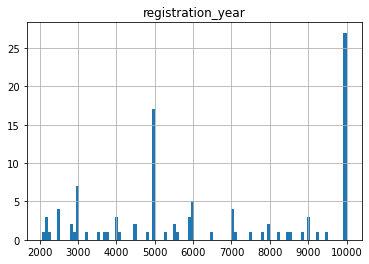

In [45]:
df[df['registration_year']>2022].hist(column='registration_year', bins = 100);

Посмотрим на строки с такими значениями:

In [46]:
df[df['registration_year']>2022].head(15)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
12946,49,unknown,5000,unknown,0,golf,5000,12,unknown,volkswagen,unknown,0
15147,0,unknown,9999,unknown,0,unknown,10000,0,unknown,sonstige_autos,unknown,0
15870,1700,unknown,3200,unknown,0,unknown,5000,0,unknown,sonstige_autos,unknown,0
17271,700,unknown,9999,unknown,0,unknown,10000,0,unknown,opel,unknown,0
17346,6500,unknown,8888,unknown,0,unknown,10000,0,unknown,sonstige_autos,unknown,0
18259,300,unknown,2200,unknown,0,twingo,5000,12,unknown,renault,unknown,0
20159,1600,unknown,4100,unknown,0,unknown,5000,0,unknown,sonstige_autos,unknown,0
26382,150,unknown,3000,unknown,0,a_klasse,5000,0,unknown,mercedes_benz,unknown,0
26560,800,unknown,2066,unknown,0,zafira,5000,0,gasoline,opel,unknown,0
28390,799,unknown,9999,unknown,0,3er,10000,4,petrol,bmw,unknown,0


Те же случайно введённые значения, а также множество "unknown" в других столбцах.

По принципу "Trash in - trash out" обучение модели станет только лучше, если такие "мусорные" значения удалить.

Сколько таких строк?

In [47]:
print('Строк с годом больше 2022:', len(df[df['registration_year']>2022]))
print('Доля датафрейма', round(100*len(df[df['registration_year']>2022])/len(df), 3), "%")

Строк с годом больше 2022: 105
Доля датафрейма 0.03 %


Удаляем:

In [48]:
df = df.loc[df['registration_year']<2022]
print('Строк с годом больше 2022:', len(df[df['registration_year']>2022]))

Строк с годом больше 2022: 0


#### Столбец "power"

Посмотрим на "ящик с усами" для этого столбца:

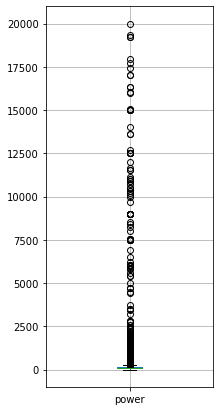

In [49]:
df[['power']].boxplot(figsize = (3, 7));

Сомнительно, что мощность автомобиля может составлять 5000 л.с. и более. 

Посмотрим на частотную гистограмму:

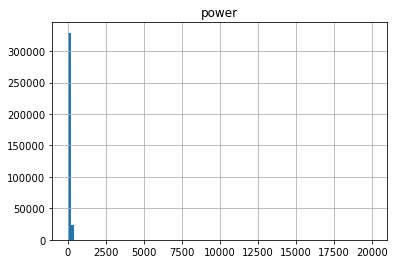

In [50]:
df.hist(column='power', bins = 100);

Приблизим левую часть графика:

Самый мощный известный автомобиль Hennessey Venom F5 поставляется с 8.0-литровым двигателем твин-турбо V8 мощностью 1600 л.с. Ограничим правдоподобный интервал этим значением.

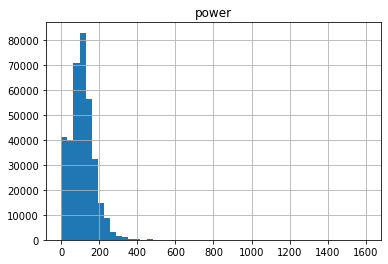

In [51]:
df[df['power']<=1600].hist(column='power', bins = 50);

Приблизим сильнее:

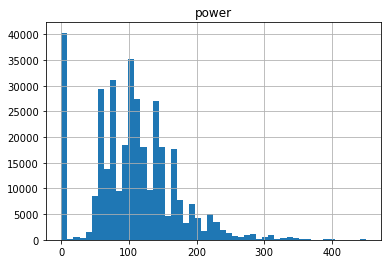

In [52]:
df[df['power']<=450].hist(column='power', bins = 50);

Заметен выброс в нуле.

Посмотрим на строки с этим значением:

In [53]:
df[df['power']==0].head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,0
15,450,small,1910,unknown,0,ka,5000,0,petrol,ford,unknown,0
32,245,sedan,1994,unknown,0,golf,150000,2,petrol,volkswagen,no,0
37,1500,unknown,2016,unknown,0,kangoo,150000,1,gasoline,renault,no,0
40,0,unknown,1990,unknown,0,corsa,150000,1,petrol,opel,unknown,0
54,4700,wagon,2005,manual,0,signum,150000,0,unknown,opel,no,0
55,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,0
69,1200,coupe,2001,unknown,0,astra,150000,0,unknown,opel,unknown,0
70,800,small,1993,manual,0,polo,150000,3,petrol,volkswagen,no,0
90,2400,sedan,2003,manual,0,a4,150000,9,gasoline,audi,unknown,0


Сколько таких строк?

In [54]:
len(df[df['power']==0])

40098

Очень много. Удалять такие данные нельзя, оставим как есть.

Посмотрим на неправдоподобно большие значения:

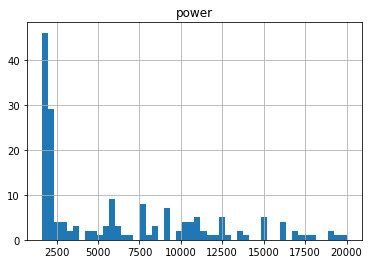

In [55]:
df[df['power']>1600].hist(column='power', bins = 50);

In [56]:
df[df['power']>1600].head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
2102,0,sedan,1999,unknown,1799,vectra,150000,1,petrol,opel,yes,0
7661,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,unknown,0
9664,2599,unknown,2016,manual,1779,zafira,150000,0,petrol,opel,no,0
9875,550,wagon,2003,manual,1753,focus,150000,1,gasoline,ford,yes,0
11039,0,sedan,1998,manual,10317,unknown,150000,8,petrol,fiat,no,0
19092,9750,wagon,2005,auto,2729,5er,150000,7,gasoline,bmw,no,0
20050,2200,sedan,2002,auto,1704,e_klasse,150000,1,unknown,mercedes_benz,yes,0
20283,2000,wagon,2003,manual,1900,c5,150000,9,gasoline,citroen,yes,0
22281,3999,sedan,1998,manual,1993,3er,150000,2,cng,bmw,unknown,0
25232,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no,0


Сколько таких строк?

In [57]:
len(df[df['power']>1600])

175

In [58]:
print('Строк с годом больше 2022:', len(df[df['power']>1600]))
print('Доля датафрейма', round(100*len(df[df['power']>1600])/len(df), 3), "%")

Строк с годом больше 2022: 175
Доля датафрейма 0.049 %


Сколько из них не содержат целевого значения - цены?

In [59]:
len(df.loc[(df['power']>1600) & (df['price']==0)])
print('Доля датафрейма', round(100*len(df.loc[(df['power']>1600) & (df['price']==0)])/len(df), 3), "%")

Доля датафрейма 0.003 %


Эти строки удаляем, в них нет ценной информации для обучения модели.

In [60]:
df = df.loc[(df['power']<1600) & (df['price']!=0)]
len(df.loc[(df['power']>1600) & (df['price']==0)]) # проверка

0

In [61]:
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,0
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354359,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,0
354361,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown,0
354362,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,0
354363,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,0


#### Столбец "kilometer"

Посмотрим на "ящик с усами" для этого столбца:

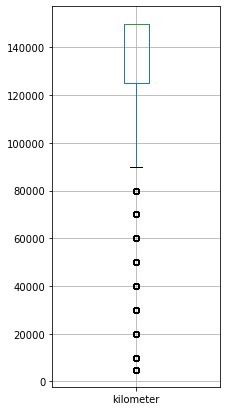

In [62]:
df[['kilometer']].boxplot(figsize = (3, 7));



Посмотрим на частотную гистограмму:

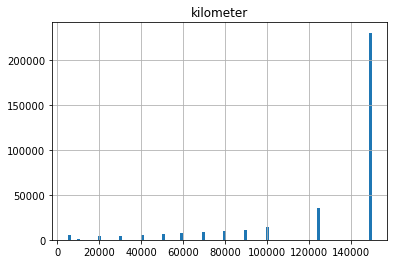

In [63]:
df.hist(column='kilometer', bins = 100);

Значения выглядят странно однообразно, но в целом правдоподобно.

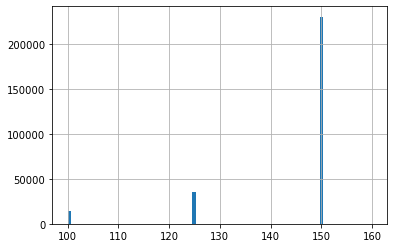

In [64]:
(df['kilometer']/1000).hist(bins = 100, range = (100, 160));
# разделим на 1000, чтобы подпись оси была в тасячах км

Странно, что значения округлены и установились в точках 100 тыс км, 125 тыс км и 150 тыс км. 

Это не слишком хорошо для обучения модели, но поделать с этим ничего нельзя.

#### Столбец "registration_month"



Посмотрим на частотную гистограмму:

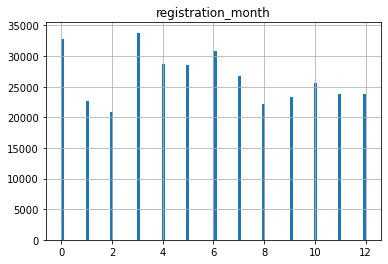

In [65]:
df.hist(column='registration_month', bins = 100);

Значения распределены равномерно. 

Есть значимая доля значений "0", но заполнить по смыслу или удалить мы их не может, оставляем как есть.

#### Столбец "number_of_pictures"

In [66]:
df['number_of_pictures'].describe()

count    343287.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

В этом столбце все значения равны нулю, полезной информации для обучения в нём нет. Удалим столбец.

In [67]:
df = df.drop(['number_of_pictures'], axis=1)
df.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown


#### Столбец "price"

Посмотрим на "ящик с усами" для этого столбца:

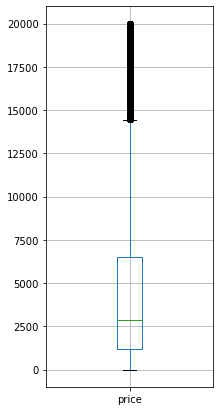

In [68]:
df[['price']].boxplot(figsize = (3, 7));

Отметим, что медианная цена немного выше 2500 евро, а минимум на нуле. Может ли цена быть нулевой?

Посмотрим на частотную гистограмму:

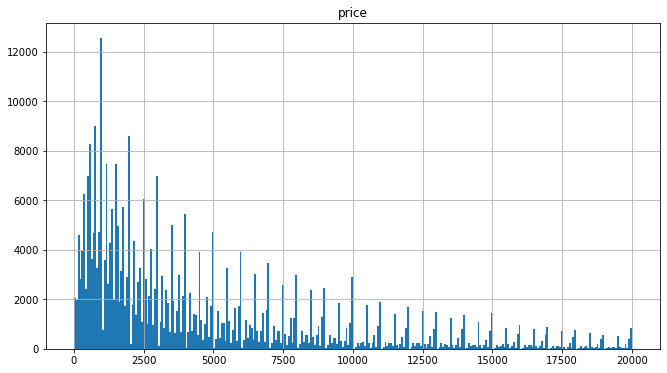

In [69]:
df.hist(column='price', bins = 300, figsize = (11, 6));

Пока выглядит правдоподобно, частота встречаемости повышается примерно до 1000 евро, далее плавно снижается с пиками вокруг "круглых" чисел. График напоминает распределение Пуассона.

Приблизим левую часть графика:

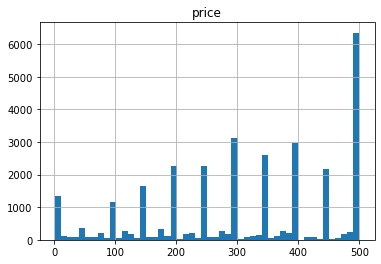

In [70]:
df[df['price']<=500].hist(column='price', bins = 50);

Заметен выброс вначале. Больше 1000 значений.

Приблизим сильнее:

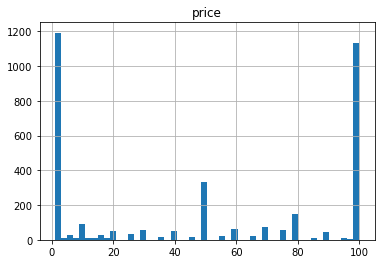

In [71]:
df[df['price']<=100].hist(column='price', bins = 50);

Аномалия около нуля. Посмотрим на такие значения:

In [72]:
df[df['price']<10].head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
59,1,suv,1994,manual,286,unknown,150000,11,unknown,sonstige_autos,unknown
89,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no
268,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no
408,1,unknown,2000,unknown,75,golf,90000,3,petrol,volkswagen,unknown
901,1,unknown,1990,manual,0,unknown,150000,0,unknown,porsche,unknown
967,1,wagon,1998,manual,136,omega,150000,0,petrol,opel,no
1025,3,convertible,1998,manual,110,mx_reihe,150000,11,unknown,mazda,yes
1247,1,sedan,1983,manual,0,unknown,150000,6,petrol,mercedes_benz,no
1340,1,unknown,2016,manual,0,golf,150000,0,gasoline,volkswagen,yes
1542,1,unknown,2000,unknown,0,astra,150000,0,unknown,opel,unknown


Можно было предположить, что эти машины - после серьёзной аварии, поэтому отдаются даром, но столбец "not_repaired" содержит разные значения.

Много значений 'unknown' в других столбцах, но есть и заполненные по смысле строки.

Если бы это был один из признаков, оставили бы как есть, чтобы не терять важные данные. Но столбец 'price' содержит целевой признак, и аномалии в нём серьёзно повлияют на качество обучения модели.

Удалим все значения ниже 100 евро, по гистограмме видно, что там начинается аномалия.

Сколько таких значений?

In [73]:
print('Строк с ценой ниже 100 евро:', len(df[df['price']<100]))
print('Доля датафрейма', round(100*len(df[df['price']<100])/len(df), 3), "%")

Строк с ценой ниже 100 евро: 2516
Доля датафрейма 0.733 %


Строк с ценой ниже 100 евро: 0


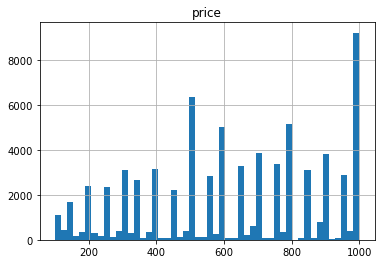

In [74]:
df = df[df['price']>=100]
print('Строк с ценой ниже 100 евро:', len(df[df['price']<100]))
df[df['price']<=1000].hist(column='price', bins = 50);

Выброса в начале больше нет. 

In [75]:
df = df.reset_index(drop=True) # после удаления лишних строк обновим индекс

Посмотрим на результат предобработки данных:

In [76]:
print('Информация:')
print(df.info())
print('--------------------------------------')
print('Дубликаты:')
print(df.duplicated().sum())
print('--------------------------------------')
print('Пропуски:')
print(df.isna().sum())

Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340771 entries, 0 to 340770
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               340771 non-null  int64 
 1   vehicle_type        340771 non-null  object
 2   registration_year   340771 non-null  int64 
 3   gearbox             340771 non-null  object
 4   power               340771 non-null  int64 
 5   model               340771 non-null  object
 6   kilometer           340771 non-null  int64 
 7   registration_month  340771 non-null  int64 
 8   fuel_type           340771 non-null  object
 9   brand               340771 non-null  object
 10  not_repaired        340771 non-null  object
dtypes: int64(5), object(6)
memory usage: 28.6+ MB
None
--------------------------------------
Дубликаты:
26079
--------------------------------------
Пропуски:
price                 0
vehicle_type          0
registration_year     0
gearbox

Данные подготовлены к обучению моделей.

## Обучение моделей

#### Разделение данных на выборки.

Разделим исходные данные на обучающую, валидационную и тестовую выборки.
- Обучающая выборка - 60%
- Валидационная выборка - 20%
- Тестовая выборка - 20%

Сначала отделим тестовую выборку, затем разделим валидационную и обучающую выборки:

In [77]:
df_train_and_valid, df_test = train_test_split(
    df, test_size=0.2, # разделяем 80% и 20% датасета
    random_state=12345 
)
df_valid, df_train = train_test_split(
    df_train_and_valid, test_size=0.75, random_state=12345,  # разделяем датасет, это будет 60 и 20% исходного
)
print("Размер обучающей выборки:",len(df_train), ", доля от данных:", len(df_train)/len(df))
print('-------------------------')
print("Размер валидационной выборки:",len(df_valid),", доля от данных:", len(df_valid)/len(df))
print('-------------------------')
print("Размер тестовой выборки:", len(df_test),", доля от данных:", len(df_test)/len(df))

Размер обучающей выборки: 204462 , доля от данных: 0.5999982392867937
-------------------------
Размер валидационной выборки: 68154 , доля от данных: 0.19999941309559793
-------------------------
Размер тестовой выборки: 68155 , доля от данных: 0.2000023476176083


#### Выделение признаков

In [78]:
features_train = df_train.drop(['price'], axis=1) # извлекаем признаки
target_train = df_train['price'] # целевой признак

features_train_and_valid = df_train_and_valid.drop(['price'], axis=1) # извлекаем признаки
target_train_and_valid = df_train_and_valid['price'] # целевой признак


features_valid = df_valid.drop(['price'], axis=1) # извлекаем признаки
target_valid = df_valid['price'] # целевой признак

features_test = df_test.drop(['price'], axis=1) # извлекаем признаки
target_test = df_test['price'] # целевой признак

print("Train/Valid/Test:", 
      features_train.shape, features_valid.shape, features_test.shape,
      target_train.shape, target_valid.shape, target_test.shape
     )

Train/Valid/Test: (204462, 10) (68154, 10) (68155, 10) (204462,) (68154,) (68155,)


### Модель Линейная регрессия

Преобразуем категориальные признаки при помощи One-Hot Encoder, a числовые StandardScaler. Чтобы одновременно применить их на один набор признаков, используем  ColumnTransformer и Pipeline.

In [79]:
OHE = OneHotEncoder(handle_unknown = 'ignore')
scaler = StandardScaler()

cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
num_cols = ['registration_year', 'power', 'kilometer', 'registration_month']

transformer = ColumnTransformer([('cat_cols', OHE, cat_cols),
                                ('num_cols', scaler, num_cols)],
                                remainder='passthrough'
                               )
LinReg = Pipeline(
    [('transforming', transformer),
     ('linreg', LinearRegression())]
)

LinReg.fit(features_train, target_train)
predicted_valid = LinReg.predict(features_valid)
rmse_linear = mean_squared_error(target_valid, predicted_valid, squared=False)
print('RMSE =', round(rmse_linear, 2))

RMSE = 2743.61



### Модель Решающее дерево

#### Ordinal Encoding

Для модели Решающее дерево закодируем категориальные признаки через Ordinal Encoding. Для нахождения оптимальной глубины дерева решенийиспользуем GridSearch.

#### Обучение модели

In [80]:
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = 500)
scaler = StandardScaler()

cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
num_cols = ['registration_year', 'power', 'kilometer', 'registration_month']

transformer = ColumnTransformer([('cat_cols', encoder, cat_cols),
                                ('num_cols', scaler, num_cols)],
                                remainder='passthrough'
                               )
pipe_tree = Pipeline([('transform', transformer),
                      ('tree', DecisionTreeRegressor(random_state=12345))])
grid_params_tree = [{'tree__max_depth' : range(1, 10)}]
tree_search = GridSearchCV(estimator=pipe_tree,
            param_grid=grid_params_tree,
            scoring='neg_root_mean_squared_error',
            cv=10, 
            n_jobs=-1)
tree_search.fit(features_train, target_train)
print('Best params are : %s' % tree_search.best_params_)
print('Best training rmse: %.3f' % abs(tree_search.best_score_))

Best params are : {'tree__max_depth': 9}
Best training rmse: 2083.331


Работа модели с оптимальной глубиной:

In [81]:
TreeReg = tree_search.best_estimator_
predicted_valid = tree_search.predict(features_valid)
rmse_tree = mean_squared_error(target_valid, predicted_valid, squared=False)
print('RMSE =', round(rmse_tree, 2))

RMSE = 2090.17


### Модель Случайный лес

#### Подбор гиперпараметров

Напишем цикл для нахождения оптимального числа деревьев и глубины дерева:

In [82]:
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = 500)
scaler = StandardScaler()

cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
num_cols = ['registration_year', 'power', 'kilometer', 'registration_month']

transformer = ColumnTransformer([('cat_cols', encoder, cat_cols),
                                ('num_cols', scaler, num_cols)],
                                remainder='passthrough'
                               )
pipe_forest = Pipeline([('transform', transformer),
                      ('forest', RandomForestRegressor(random_state=12345))])
grid_params_forest = [{'forest__n_estimators': range(10, 110, 10),
                   'forest__max_depth': range(1, 15)}]
forest_search = GridSearchCV(estimator=pipe_forest,
            param_grid=grid_params_forest,
            scoring='neg_root_mean_squared_error',
            cv=10, 
            n_jobs=-1)
forest_search.fit(features_train, target_train)
print('Best params are : %s' % forest_search.best_params_)
print('Best training rmse: %.3f' % abs(forest_search.best_score_))

Best params are : {'forest__max_depth': 14, 'forest__n_estimators': 90}
Best training rmse: 1719.206


### Обучение модели

Выполним предсказание модели с наилучшими гиперпараметрами:

In [83]:
ForestReg = forest_search.best_estimator_
predicted_valid = forest_search.predict(features_valid)
rmse_forest = mean_squared_error(target_valid, predicted_valid, squared=False) # считаем RMSE
print("RMSE:", round(rmse_forest, 2))

RMSE: 1713.49


### Модель LightGBM

Модель LightGBM может обрабатывать категориальные и числовые признаки кодирования и масштабирования.

Подготавливаем типы данных категориальных признаков:

In [84]:
cat_features = ['vehicle_type', 'gearbox', 'model', 
                'fuel_type', 'brand', 'not_repaired']
features_train[cat_features] = features_train[cat_features].astype('category')
features_valid[cat_features] = features_valid[cat_features].astype('category')
features_test[cat_features] = features_test[cat_features].astype('category')
features_train_and_valid[cat_features] = features_train_and_valid[cat_features].astype('category')

#### Подбор гиперпараметров

In [85]:
LightReg = lgb.LGBMRegressor(random_state=12345,
                             metric = 'l2_root',
                             n_jobs = -1)
grid_params_light = [{'n_estimators' : range(50, 110, 10),
                      'num_leaves'   : range(5, 50, 5),
                      'learning_rate': [0.1, 0.3, 0.5, 0.7]}]
light_search = GridSearchCV(estimator=LightReg,
            param_grid=grid_params_light,
            scoring='neg_root_mean_squared_error',
            cv=10, 
            n_jobs=-1)
light_search.fit(features_train, target_train)
print('Best params are : %s' % light_search.best_params_)
print('Best training rmse: %.3f' % abs(light_search.best_score_))

Best params are : {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 45}
Best training rmse: 1623.574


#### Обучение модели

Обучим модель с наилучшими найденными гиперпараметрами.

In [86]:
LightReg = light_search.best_estimator_
LightReg.fit(features_train, target_train, categorical_feature = 'auto')
predicted_valid = LightReg.predict(features_valid)
rmse_light = mean_squared_error(target_valid, predicted_valid, squared=False) # считаем RMSE
print("RMSE:", round(rmse_light, 2))

RMSE: 1627.5


### Модель CatBoost 

#### Подбор гиперпараметров

Внесём изменения в некоторые параметры, которые могут сильно повлиять на результат обучения. Это максимальная глубина дерева depth, скорость обучения learning_rate и количество деревьев в ансамбле iterations.

In [87]:
CatBReg = CatBoostRegressor(random_state=12345,
                            loss_function="RMSE",
                            cat_features=cat_features)
grid_params_cat = [{'iterations'     : range(10, 120, 10),
                      'depth'        : range(1, 7),
                      'learning_rate': [0.1, 0.4, 0.6, 0.8, 1]}]
cat_search = GridSearchCV(estimator=CatBReg,
            param_grid=grid_params_cat,
            scoring='neg_root_mean_squared_error',
            cv=10, 
            n_jobs=-1,
            verbose=False)
cat_search.fit(features_train, target_train)
print('Best params are : %s' % cat_search.best_params_)
print('Best training rmse: %.3f' % abs(cat_search.best_score_))

0:	learn: 2855.8680973	total: 309ms	remaining: 33.7s
1:	learn: 2456.9082930	total: 499ms	remaining: 26.9s
2:	learn: 2278.3591232	total: 703ms	remaining: 25.1s
3:	learn: 2187.8125492	total: 885ms	remaining: 23.4s
4:	learn: 2134.2912655	total: 1.06s	remaining: 22.2s
5:	learn: 2075.0123806	total: 1.22s	remaining: 21.1s
6:	learn: 2013.2712184	total: 1.4s	remaining: 20.6s
7:	learn: 1994.4539584	total: 1.58s	remaining: 20.1s
8:	learn: 1972.1447541	total: 1.73s	remaining: 19.4s
9:	learn: 1955.5351295	total: 1.88s	remaining: 18.8s
10:	learn: 1932.8527067	total: 2.04s	remaining: 18.3s
11:	learn: 1921.6458749	total: 2.19s	remaining: 17.9s
12:	learn: 1907.0849363	total: 2.34s	remaining: 17.5s
13:	learn: 1885.0779459	total: 2.5s	remaining: 17.2s
14:	learn: 1877.6321181	total: 2.65s	remaining: 16.8s
15:	learn: 1869.1265821	total: 2.81s	remaining: 16.5s
16:	learn: 1863.3594792	total: 2.97s	remaining: 16.2s
17:	learn: 1853.6185602	total: 3.13s	remaining: 16s
18:	learn: 1845.0495776	total: 3.3s	remain

#### Обучение модели

Работа модели с наилучшими гиперпараметрами:

In [88]:
CatBReg = cat_search.best_estimator_
CatBReg.fit(features_train, target_train, verbose=False)
predicted_valid = CatBReg.predict(features_valid)
rmse_cat = mean_squared_error(target_valid, predicted_valid, squared=False) # считаем RMSE
print("RMSE:", round(rmse_cat, 2))

RMSE: 1720.09


### Константная модель 

Для проверки моделей на адекватность сравним их работу с константной моделью, которая всегда даёт в качестве ответа медианное значение целевого признака в обучающей выборке.

In [89]:
median_const = target_train.median()
predicted_valid = pd.Series([median_const]*len(target_valid))
rmse_constant = mean_squared_error(target_valid, predicted_valid, squared=False) # считаем RMSE
print("RMSE константной модели:", round(rmse_constant, 2))

RMSE константной модели: 4834.08


Все модели проходят проверку на адекватность и опережают константную модель по значению RMSE.

## Анализ моделей

Проанализируем качество и время работы моделей на тестовой выборке.

Понадобится функция, проводящая тест модели. 

**На вход** она будет получать модель, а также обучающие и тестовые признаки. 

**На выход** она будет выдавать полученные характеристики модели в виде списка:
- RMSE на тестовой выборке
- Время обучения
- Время предсказания

In [97]:
def model_test(model, features_train, target_train, features_test, target_test):
    train_time = %timeit -r3 -n1 -o model.fit(features_train, target_train)
    predicted_test = model.predict(features_test)
    predict_time = %timeit -r3 -n1 -o predicted_test = model.predict(features_test)
    rmse = mean_squared_error(target_test, predicted_test, squared=False)
    print('RMSE =', round(rmse, 2))
    print('Время обучения', round(train_time.average, 2), 'сек')
    print('Время предсказания', round(predict_time.average, 2), 'сек')
    return([rmse, predict_time.average, train_time.average])

### Модель Линейная регрессия

In [98]:
LinReg_result = model_test(LinReg, features_train_and_valid, target_train_and_valid, features_test, target_test)

8.21 s ± 123 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
138 ms ± 8.23 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
RMSE = 2743.08
Время обучения 8.21 сек
Время предсказания 0.14 сек



### Модель Решающее дерево

In [99]:
TreeReg_result = model_test(TreeReg, features_train_and_valid, target_train_and_valid, features_test, target_test)

1.4 s ± 46.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
122 ms ± 6.68 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
RMSE = 2111.46
Время обучения 1.4 сек
Время предсказания 0.12 сек


### Модель Случайный лес

In [100]:
ForestReg_result = model_test(ForestReg, features_train_and_valid, target_train_and_valid, features_test, target_test)

1min 11s ± 3.22 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
985 ms ± 13.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
RMSE = 1731.91
Время обучения 71.56 сек
Время предсказания 0.99 сек


### Модель LightGBM

In [101]:
LightReg_result = model_test(LightReg, features_train_and_valid, target_train_and_valid, features_test, target_test)

1.39 s ± 83.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
173 ms ± 3.53 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
RMSE = 1640.9
Время обучения 1.39 сек
Время предсказания 0.17 сек


### Модель CatBoost 

In [102]:
CatBReg_result = model_test(CatBReg, features_train_and_valid, target_train_and_valid, features_test, target_test)

0:	learn: 2791.2727999	total: 212ms	remaining: 23.1s
1:	learn: 2404.4360655	total: 413ms	remaining: 22.3s
2:	learn: 2241.9226619	total: 611ms	remaining: 21.8s
3:	learn: 2141.2556678	total: 801ms	remaining: 21.2s
4:	learn: 2069.9525282	total: 982ms	remaining: 20.6s
5:	learn: 2024.1264317	total: 1.2s	remaining: 20.7s
6:	learn: 1994.5425785	total: 1.38s	remaining: 20.3s
7:	learn: 1967.1622901	total: 1.58s	remaining: 20.2s
8:	learn: 1955.6540065	total: 1.79s	remaining: 20.1s
9:	learn: 1938.6006911	total: 2.06s	remaining: 20.7s
10:	learn: 1928.1492461	total: 2.25s	remaining: 20.3s
11:	learn: 1913.4167774	total: 2.44s	remaining: 20s
12:	learn: 1903.9551091	total: 2.66s	remaining: 19.8s
13:	learn: 1893.1876627	total: 2.88s	remaining: 19.8s
14:	learn: 1886.2773726	total: 3.09s	remaining: 19.6s
15:	learn: 1876.8448147	total: 3.32s	remaining: 19.5s
16:	learn: 1868.6095193	total: 3.51s	remaining: 19.2s
17:	learn: 1854.4238484	total: 3.69s	remaining: 18.8s
18:	learn: 1844.3454953	total: 3.92s	rema

43:	learn: 1733.6981645	total: 8.58s	remaining: 12.9s
44:	learn: 1732.4311380	total: 8.79s	remaining: 12.7s
45:	learn: 1729.8851941	total: 8.98s	remaining: 12.5s
46:	learn: 1727.1862381	total: 9.18s	remaining: 12.3s
47:	learn: 1725.7303299	total: 9.38s	remaining: 12.1s
48:	learn: 1723.9350182	total: 9.62s	remaining: 12s
49:	learn: 1722.1357261	total: 9.82s	remaining: 11.8s
50:	learn: 1720.3071313	total: 10.1s	remaining: 11.7s
51:	learn: 1717.9988605	total: 10.3s	remaining: 11.4s
52:	learn: 1716.2689891	total: 10.5s	remaining: 11.3s
53:	learn: 1713.2145112	total: 10.7s	remaining: 11.1s
54:	learn: 1710.9034739	total: 10.9s	remaining: 10.9s
55:	learn: 1708.4828358	total: 11.1s	remaining: 10.7s
56:	learn: 1706.9067883	total: 11.3s	remaining: 10.5s
57:	learn: 1705.6661439	total: 11.5s	remaining: 10.3s
58:	learn: 1704.0557348	total: 11.6s	remaining: 10.1s
59:	learn: 1702.6505939	total: 11.8s	remaining: 9.86s
60:	learn: 1701.2577410	total: 12s	remaining: 9.66s
61:	learn: 1698.0343632	total: 1

86:	learn: 1663.2893085	total: 17.4s	remaining: 4.59s
87:	learn: 1662.3949441	total: 17.6s	remaining: 4.39s
88:	learn: 1660.7109968	total: 17.8s	remaining: 4.19s
89:	learn: 1660.1110707	total: 18s	remaining: 4s
90:	learn: 1658.8273028	total: 18.2s	remaining: 3.8s
91:	learn: 1657.8181576	total: 18.4s	remaining: 3.6s
92:	learn: 1656.5113768	total: 18.6s	remaining: 3.39s
93:	learn: 1654.4930687	total: 18.7s	remaining: 3.19s
94:	learn: 1653.5335599	total: 18.9s	remaining: 2.99s
95:	learn: 1652.0525071	total: 19.2s	remaining: 2.8s
96:	learn: 1651.2021257	total: 19.4s	remaining: 2.6s
97:	learn: 1650.8683279	total: 19.6s	remaining: 2.4s
98:	learn: 1649.2824820	total: 19.8s	remaining: 2.2s
99:	learn: 1647.7091449	total: 20s	remaining: 2s
100:	learn: 1647.1859854	total: 20.2s	remaining: 1.8s
101:	learn: 1645.4817520	total: 20.4s	remaining: 1.6s
102:	learn: 1644.7244863	total: 20.7s	remaining: 1.4s
103:	learn: 1643.8937736	total: 20.9s	remaining: 1.2s
104:	learn: 1642.2412000	total: 21s	remainin

## Итоги

Соберём полученные RMSE и время работы каждой модели в секундах в единый датафрейм.

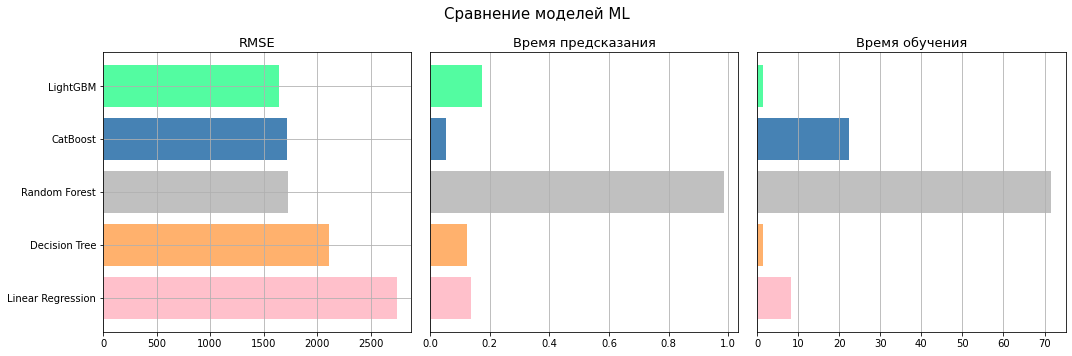

,RMSE,predict_time,train_time
model,,,
LightGBM,1640.899914,0.173477,1.386737
CatBoost,1720.064209,0.053013,22.403433
Random Forest,1731.910825,0.985484,71.559744
Decision Tree,2111.458484,0.122390,1.396424
Linear Regression,2743.078699,0.138445,8.207188


In [103]:
models_analysis = pd.concat(
    [pd.DataFrame(
        data = [
            LinReg_result,
            TreeReg_result,
            ForestReg_result,
            LightReg_result,
            CatBReg_result,
            ], 
        columns = ['RMSE', 'predict_time', 'train_time']
    ), pd.DataFrame(['Linear Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'CatBoost'],
        columns = ['model'])], sort=False, axis=1
).set_index('model').sort_values(by = 'RMSE', ascending = False)

# Графики сравнения
colors = ['pink', 'xkcd:apricot', 'silver', 'steelblue', 'xkcd:sea green']
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15,5), nrows=1, ncols=3)
fig.suptitle('Сравнение моделей ML', fontsize=15)
x = models_analysis.index
ax1.barh(x, models_analysis['RMSE'], label = 'RMSE', color = colors)
ax1.set_title('RMSE', fontsize=13)
ax1.grid()
ax2.barh(x, models_analysis['predict_time'], label = 'Время предсказания', color = colors)
ax2.set_title('Время предсказания', fontsize=13)
ax2.grid()
ax2.get_yaxis().set_visible(False)
ax3.barh(x, models_analysis['train_time'], label = 'Время обучения', color = colors)
ax3.set_title('Время обучения', fontsize=13)
ax3.grid()
ax3.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
display(models_analysis.sort_values(by = 'RMSE'))

Результаты сравнения:
- Наименьшее RMSE - у модели LightGBM, но отличия от CatBoost и Случайного леса незначительные.
- Наименьшее время предсказания у модели CatBoost, далее идут Решающее дерево и Линейная Регрессия.
- Быстрее всех обучается Решающее дерево, далее LightGBM и CatBoost.


### Обзор выполненной работы:
- Были обработаны исторические данные объявлений о продаже автомобилей:
    - Убраны неинформативные столбцы
    - Заполнены пропуски
    - Удалены "мусорные" строки
- Подготовлены признаки для моделей:
    - Линейная регрессия
    - Решающее дерево
    - Случайный лес
    - LightGBM
    - CatBoost
- По параметрам качества обучения, скорости предсказания и скорости обучения подобрана оптимальная модель машинного обучения.

## Вывод:
- По итогам анализа данных построена модель предсказания рыночной стоимости автомобиля
- Выбрана модель CatBoost:
    - По первому по значимости параметру - RMSE - три модели показывают примерно одинаковые результаты.
    - По скорости предсказания CatBoost существенно обходит две другие модели из предыдущего пункта. Время предсказания модели CatBoost составляет 0,05 сек.
    - По скорости обучения CatBoost находится на втором месте.
- Также можно рассмотреть модель LightGBM, она опережает CatBoost по времени обучения(1,38 с против 22,4 с), но проигрывает по времени предсказания более чем в 3 раза - результат 0,17 секунды против 0,05. При разработке и тестировании приложения можно принять окончательное решение.
- Скорость обучения модели CatBoost составляет 22,4 секунды
- Качество предсказания модели CatBoost на высоком уровне, RMSE составляет 1720 евро при требуемом значении не более 2500.